# Locating maximum strain on riser by using RNN

### Introduction
This notebook presents a method to predict the location of maximum strain on a riser by using a recurrent neural network (RNN). The data used are from the NDP high mode VIV tests and as a starting point only a single test case is used here. In the test, the acceleration of the riser was measured at 8 locations in cross-flow and in-line direction. The riser strain was measured at 24 locations for cross-flow and 44 locations for in-line. The idea of this model is to use the acceleration measurements to predict which of the 24 cross-flow strain sensors will experience the maximum strain. The prediction is made for each time step and a RNN is applied since measurements close in time are assumed to be correlated.

In [1]:
import scipy.io
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, TimeDistributed, Dropout, MaxPooling1D, MaxPooling2D, Conv1D, Conv2D, Input, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import itertools
from matplotlib import animation
%matplotlib inline

### Loading data

In [2]:
text_df = pd.read_csv("TD_CONDITIONSET_uniform_3D.txt", delimiter = "\t", header=None)
text = text_df.values

### Preparation of data

First the time vector is generated. The experiments were done with a sampling frequency of 1200 Hz. The initial part and the last part of the data is discarded as it is loaded in. 

The location of the sensors in meters are also included.

The location of the maximum value of the strain is found in CF and IL for each time step.

### Preparing data for RNN

An input tensor X, and output vector Y is made.

X is scaled by a standard scaler. Y is the integer to be predicted.

Data are divided into batches, where the time in each batch is conserved.

Each batch is randomly put in either train, test or validation set.

The time is removed from the input.

In [3]:
list_inputs = []
list_outputs = []
n_tests = 1

for i in range(0,n_tests):
    file = os.path.join("Data", f"test{int(text[i,0])}.mat")
    mat = scipy.io.loadmat(file)

    chan_names = mat['chan_names']
    data = mat['data']
    
    D = 0.027 # Riser diameter
    U =  text[i,1]
    C = U**2/D
    
    # Time parameters
    t1 = text[i,10] # Start time
    t2 = text[i,11] # End time
    Fs = 1200 # Sampling freq
    dt = 1/Fs # Time step
    tst = int(t1*Fs) # Index for start
    ted = int(t2*Fs) # Index for end

    # Making a time vector
    nm = data.shape[1]
    time = np.arange(0,nm-1)*dt
    time = time[tst:ted].reshape(1,-1)

    # Defining feature vectors and cropping them from initial/end effects
    strain_CF = data[46:70,tst:ted]
    strain_CF_names = chan_names[46:70]
    strain_IL = data[6:46,tst:ted]
    strain_IL_names = chan_names[6:46]
    pos_IL = data[98:106,tst:ted] / D
    pos_CF = data[106:114,tst:ted] / D
    acc_IL = data[70:78,tst:ted] / C
    acc_IL_names = chan_names[70:78]
    acc_CF = data[78:86,tst:ted] / C
    acc_CF_names = chan_names[78:86]
    mean_force = data[95:97,tst:ted].mean(axis=0)
    u = np.ones(mean_force.shape)*U

    # Strain sensor positions
    str_il = np.array([1.143,2.555,3.084,3.224,4.155,5.759,6.030,7.664,8.216,8.609,8.889,9.703,10.285,13.676,13.772,
                         15.393,16.452,16.547,16.891,19.997,20.193,21.393,21.603,22.460,23.165,25.153,25.442,26.254,27.532,
                         28.698,28.863,29.365,31.191,31.415,32.796,33.005,35.549,36.559,36.824,37.322])
    str_sensor_cf = np.array([2,3,4,5,7,10,11,13,14,17,19,20,21,22,24,25,26,28,31,32,33,36,38,40])-1
    str_cf = str_il[str_sensor_cf]

    # Accelerometer positions
    acc_pos = np.array([4.155,8.609,13.676,16.891,21.393,25.153,28.863,33.005])

    # Finding indices for strain locations which will be fused 
    sensor_diff_il = np.abs(np.tile(str_il,(8,1)).T - acc_pos)
    sensor_transform_index_il = np.argmin(sensor_diff_il,axis=1)
    sensor_diff_cf = np.abs(np.tile(str_cf,(8,1)).T - acc_pos)
    sensor_transform_index_cf = np.argmin(sensor_diff_cf,axis=1)

    # Find maximum strain locations for each time step
    max_strain_IL = strain_IL.argmax(axis=0)
    max_strain_CF = strain_CF.argmax(axis=0)
    max_strain_IL_loc = str_il[max_strain_IL]
    max_strain_CF_loc = str_cf[max_strain_CF]
    
    #norm_strain = strain_CF/np.abs(strain_CF).sum(axis=0)
    norm_strain = strain_CF
    max_strain = norm_strain.argmax(axis=0)
    
    #Xi = np.vstack((time,pos_IL,pos_CF,acc_IL,acc_CF)).transpose()
    Xi = np.vstack((time,pos_CF,acc_CF)).transpose()
    Yi = np.vstack(norm_strain).transpose()
    
    scaler = StandardScaler()
    scaler.fit(Xi)
    Xi = scaler.transform(Xi)
    scaler = StandardScaler()
    scaler.fit(Yi)
    Yi = scaler.transform(Yi)
    
    b_size = 1000
    n_batches = Xi.shape[0]//b_size

    if not n_batches == 0:
        n_batches = Xi.shape[0] // b_size
        Xi = Xi[:n_batches*b_size,:]
        Yi = Yi[:n_batches*b_size,:]

    n_features = Xi.shape[1]
    n_outputs = Yi.shape[1]

    Xi = Xi.reshape(n_batches,b_size,n_features)
    Yi = Yi.reshape(n_batches,b_size,n_outputs)
    
    list_inputs.append(Xi)
    list_outputs.append(Yi)

X = np.concatenate(([list_inputs[i] for i in range(0,n_tests)]),axis=0)
Y = np.concatenate(([list_outputs[i] for i in range(0,n_tests)]),axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=1, shuffle=False)

t_train = X_train[:,:,0]
t_val = X_val[:,:,0]
t_test = X_test[:,:,0]
X_train = X_train[:,:,1:]
X_test = X_test[:,:,1:]
X_val = X_val[:,:,1:]

#n_outputs = Y.max()+1
n_features = n_features-1

print(f'X-train: (batches, time steps in batch, features) = {X_train.shape}')
print(f'Y-train: (batches, time steps in batch, output)   = {y_train.shape}')
print(f'X-valid: (batches, time steps in batch, features) = {X_val.shape}')
print(f'Y-valid: (batches, time steps in batch, output)   = {y_val.shape}')
print(f'X-test : (batches, time steps in batch, features) = {X_test.shape}')
print(f'Y-test : (batches, time steps in batch, output)   = {y_test.shape}')

X-train: (batches, time steps in batch, features) = (90, 1000, 16)
Y-train: (batches, time steps in batch, output)   = (90, 1000, 24)
X-valid: (batches, time steps in batch, features) = (45, 1000, 16)
Y-valid: (batches, time steps in batch, output)   = (45, 1000, 24)
X-test : (batches, time steps in batch, features) = (45, 1000, 16)
Y-test : (batches, time steps in batch, output)   = (45, 1000, 24)


### Building RNN model

This model will use sparse_categorical_crossentropy, which means that if the true output can be $n \in 0:N$ different integers, then the prediction will be an array of size $N+1$ where each unit indicates a probability of the index.


In [4]:
# Regression
model = Sequential(name='LSTM')
model.add(LSTM(
    units=500,
    batch_input_shape=(None,X.shape[1],n_features),
    return_sequences=True,
    dropout=0,
    recurrent_dropout=0,
    activation='tanh'))
#model.add(Dense(40,activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(n_outputs, activation='linear'))

model.summary()
model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mean_squared_error'])

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1000, 500)         1034000   
_________________________________________________________________
dense (Dense)                (None, 1000, 24)          12024     
Total params: 1,046,024
Trainable params: 1,046,024
Non-trainable params: 0
_________________________________________________________________


### Training model

Using an early stopping criteria.

Can continue training for a max of 100 epochs.

Validation data is used at each epoch.

In [5]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train,y_train,epochs=100,callbacks=callback,validation_data=(X_val, y_val),verbose=True)
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

Epoch 1/100
3/3 [==============================] - 24s 8s/step - loss: 0.7363 - mean_squared_error: 0.7363 - val_loss: 0.6017 - val_mean_squared_error: 0.6017
Epoch 2/100
3/3 [==============================] - 21s 7s/step - loss: 0.4170 - mean_squared_error: 0.4170 - val_loss: 0.4160 - val_mean_squared_error: 0.4160
Epoch 3/100
3/3 [==============================] - 22s 8s/step - loss: 0.3272 - mean_squared_error: 0.3272 - val_loss: 0.3416 - val_mean_squared_error: 0.3416
Epoch 4/100
3/3 [==============================] - 22s 8s/step - loss: 0.2851 - mean_squared_error: 0.2851 - val_loss: 0.3039 - val_mean_squared_error: 0.3039
Epoch 5/100
3/3 [==============================] - 22s 8s/step - loss: 0.2595 - mean_squared_error: 0.2595 - val_loss: 0.2692 - val_mean_squared_error: 0.2692
Epoch 6/100
3/3 [==============================] - 23s 8s/step - loss: 0.2460 - mean_squared_error: 0.2460 - val_loss: 0.2488 - val_mean_squared_error: 0.2488
Epoch 7/100
3/3 [=============================

In [12]:
y_pred = model.predict(X_test)
y_pred_amax = y_pred.argmax(axis=2)
y_test_amax = y_test.argmax(axis=2)

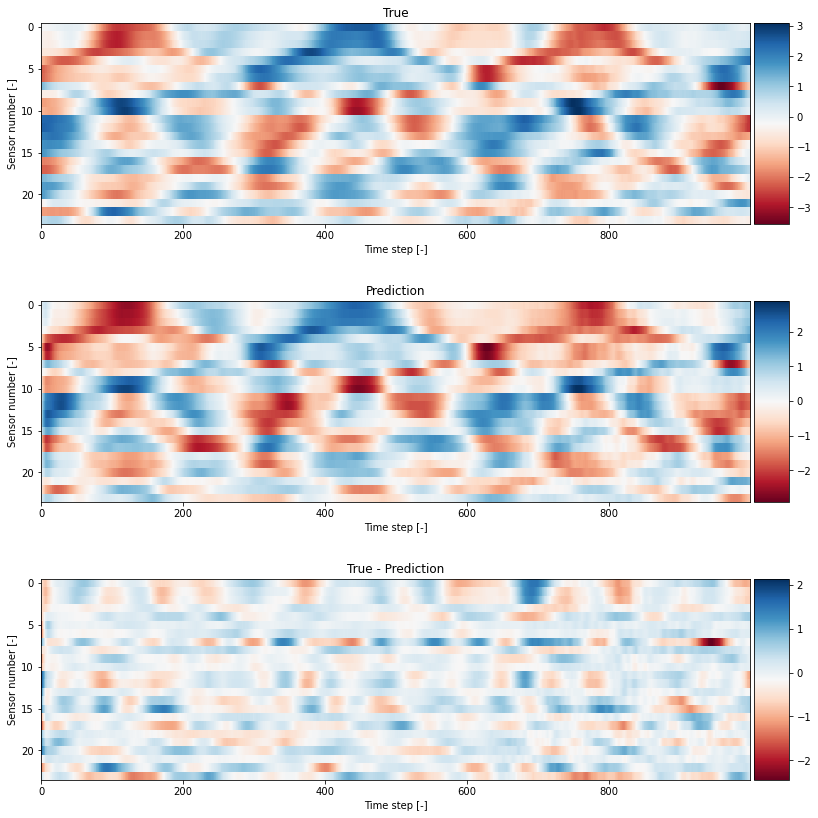

In [13]:
n = 0
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(3,figsize=(12,12))
plt1 = ax[0].imshow(y_test[n,:,:].T,cmap='RdBu',interpolation='nearest', aspect='auto')
ax[0].set_ylabel('Sensor number [-]')
ax[0].set_xlabel('Time step [-]')
ax[0].set_title('True')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(plt1, cax=cax, orientation='vertical')
plt2 = ax[1].imshow(y_pred[n,:,:].T,cmap='RdBu',interpolation='nearest', aspect='auto')
ax[1].set_ylabel('Sensor number [-]')
ax[1].set_xlabel('Time step [-]')
ax[1].set_title('Prediction')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(plt2, cax=cax, orientation='vertical')
plt3 = ax[2].imshow(y_test[n,:,:].T-y_pred[n,:,:].T,cmap='RdBu',interpolation='nearest', aspect='auto')
ax[2].set_ylabel('Sensor number [-]')
ax[2].set_xlabel('Time step [-]')
ax[2].set_title('True - Prediction')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(plt3, cax=cax, orientation='vertical')
fig.tight_layout(pad=3.0)
plt.show()

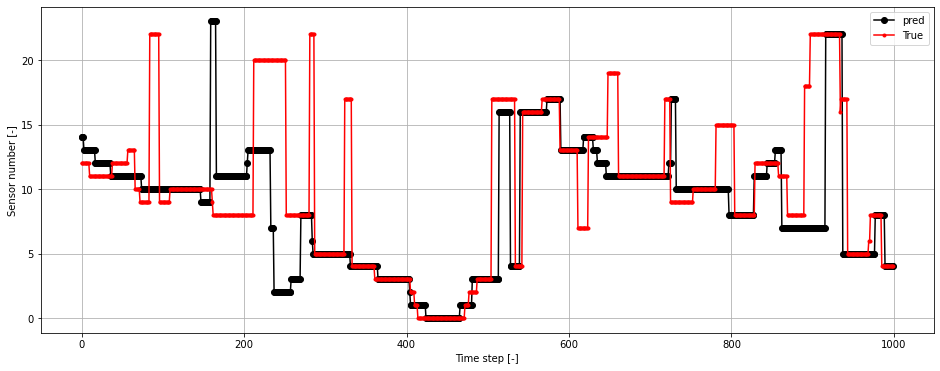

In [15]:
n = 0

plt.figure(figsize=(16,6))
plt.plot(y_pred_amax[n,:],'k-o',label='pred')
plt.plot(y_test_amax[n,:],'r.-',label='True')
plt.legend()
plt.grid()
plt.ylabel('Sensor number [-]')
plt.xlabel('Time step [-]')
plt.show()

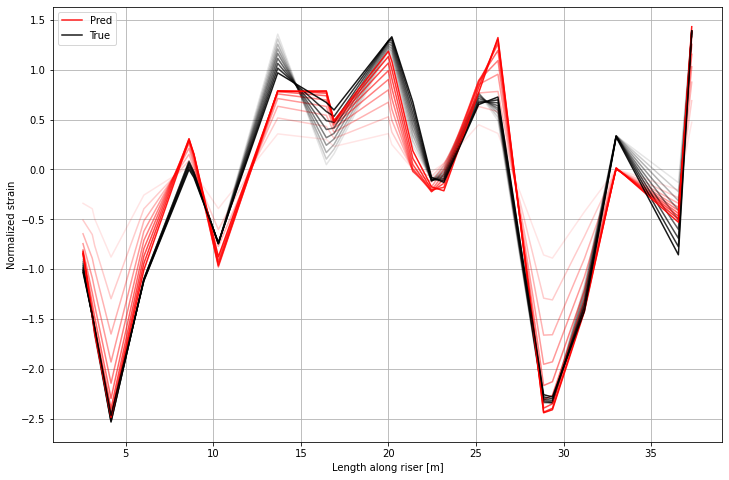

In [16]:
n = 9
its = 0
plt.figure(figsize=(12,8))
for i in range(its,its+10):
    line1,=plt.plot(str_cf,y_pred[n,i,:],'r',alpha=0.1*i)
    line2,=plt.plot(str_cf,y_test[n,i,:],'k',alpha=0.1*i)
line1.set_label('Pred')
line2.set_label('True')  
plt.grid()
plt.legend()
plt.xlabel('Length along riser [m]')
plt.ylabel('Normalized strain')
plt.show()

In [18]:
import matplotlib
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
%matplotlib qt

n = 1
fig, ax = plt.subplots()
ax.set_xlabel('Length along riser [m]')
ax.set_ylabel('Normalized strain')
ax.set_xlim([0,40])
ax.set_ylim([-5,5])
line1, = ax.plot(str_cf,y_pred[n,0,:],label='Prediction')
line2, = ax.plot(str_cf,y_test[n,0,:],label='True')

def animate(i):
    x_data = str_cf
    line1.set_xdata(x_data)
    line1.set_ydata(y_pred[n,i,:])
    line2.set_xdata(x_data)
    line2.set_ydata(y_test[n,i,:])
    return line1,line2,

ani = FuncAnimation(fig, func=animate, frames=np.arange(0,b_size), interval=10)
ani = FuncAnimation(fig, func=animate, frames=np.arange(0,b_size), interval=10)
plt.legend()
plt.grid()
plt.show()



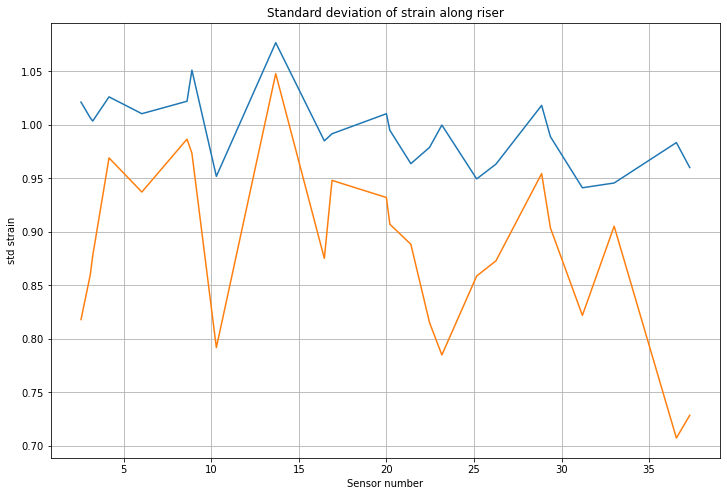

In [11]:
%matplotlib inline
fig, ax = plt.subplots(1,figsize=(12,8))
ax.plot(str_cf,y_test.reshape(-1,24).std(axis=0))
ax.plot(str_cf,y_pred.reshape(-1,24).std(axis=0))
ax.set_xlabel('Sensor number')
ax.set_ylabel('std strain')
ax.set_title('Standard deviation of strain along riser')
plt.grid()
plt.show()